In [1]:
# Image classification assignment

<a id='top'.</a>
[Table of contents](#bottom)

- [Introduction](#intro)<a id='intro'.</a>
    - [Data loading](#dl)<a id='dl'.</a>
    - [Data augmentation](#da)<a id='da'.</a>
- [InceptionV3](#iv3)<a id='iv3'.</a>
- [ResNet](#resnet)<a id='resnet'.</a>
- [MobileNet](#mobilenet)

[Table of contents](#top) [Bottom](#bottom)

## Introduction

In [1]:
import libraries
from libraries import *
%matplotlib inline

print(get_available_gpus())

# sys.stdout.flush()
print(psutil.virtual_memory())

reload(libraries)
# from libraries import *

Using TensorFlow backend.


['/gpu:0']
svmem(total=64390926336, available=55260207104, percent=14.2, used=8800632832, free=54547595264, active=8424345600, inactive=663339008, buffers=46022656, cached=996675584, shared=140070912)


<module 'libraries' from '/home/ubuntu/ssl/cookpad/nbs/libraries.py'>

#### Loading data and defining generators

In [2]:
target_size = (256, 256)
target_size_mn = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_mn = target_size_mn + (3,)

In [3]:
# path='../data/original/sushi_or_sandwich/'
path='../data/original/sushi_or_sandwich/'
x_train, y_train, x_test, y_test, mean_set, std_set = load_data(split=0.8, path=path)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

(800, 256, 256, 3) (800,)
(640, 256, 256, 3) (640,) (160, 256, 256, 3) (160,) 0.527196 0.283016


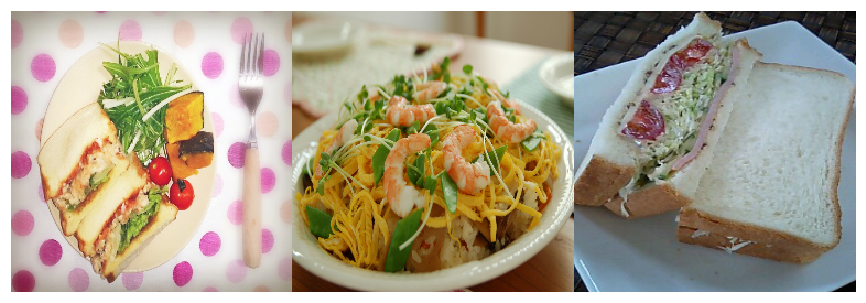

In [4]:
plot_images(x_train[:3])

In [5]:
# visualize what the loading process already does: 
# 1. rescales data between 0 and 1
# 2. doesnt normalize - that is applied during batchnorm, data augmentation

x_train_n = (x_train - mean_set) / std_set
x_test_n = (x_test - mean_set) / std_set

x_train_r = x_train * 255
x_test_r = x_test * 255

print(x_test.min(), x_test.max(), x_test.mean(), x_test.std())
print(x_test_n.min(), x_test_n.max(), x_test_n.mean(), x_test_n.std())
print(x_test_r.min(), x_test_r.max(), x_test_r.mean(), x_test_r.std())

0.0 1.0 0.536460151591 0.285190643043
-1.86277555935 1.67058767286 0.0327330158258 1.0076821323
0.0 255.0 136.797338656 72.7236139759


[Go to Modeling](#section2) <a href='#section2'>Also link to section 2]</a>

<a id='section1'.</a>

## Generators

Found 800 images belonging to 2 classes.


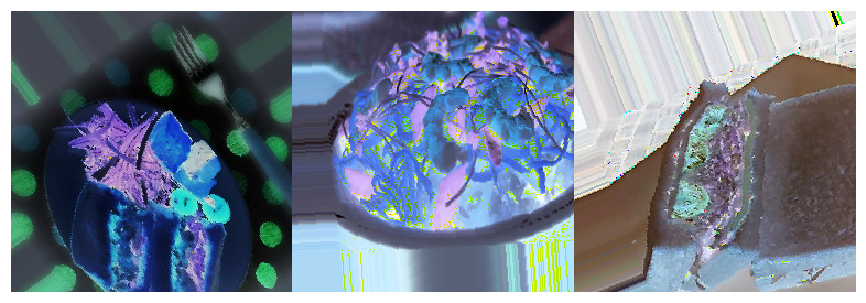

In [30]:
# plain generator

data_gen = ImageDataGenerator()

# augmented data generators
# rotation_range = 20,width_shift_range=0.5,height_shift_range=0.2):

gen_85 = ImageDataGenerator(
        rotation_range=40,  # 45
        width_shift_range=0.2, # 0.125
        height_shift_range=0.2, # 0.125
        shear_range=0.05, # 0.2
        zoom_range=0.05, # 0.2
        horizontal_flip=True,
        fill_mode='nearest')

gen_0 = ImageDataGenerator(
#         samplewise_center=True, 
#         samplewise_std_normalization=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,  # 45
        width_shift_range=0.2, # 0.125
        height_shift_range=0.2, # 0.125
        shear_range=0.05, # 0.2
        zoom_range=0.05, # 0.2
        horizontal_flip=True,
        fill_mode='nearest')
#         preprocessing_function=rescale_normalize) 

gen_0.fit(x_train, augment=10)

gen_1 = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=.9,     
    width_shift_range=.2 , # biggest impact
    height_shift_range=.2, # biggest impact   
    shear_range=.3,
    zoom_range=.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

sample = np.empty(((0,) + input_shape))
for i, j in gen_85.flow_from_directory(join(path), batch_size=3, seed=0):

    sample = np.append(sample, i, axis=0); 
    sample_lab = j
    break

plot_images(sample)

#### Data augmentation playground

In [239]:
# rotation_range = 20,width_shift_range=0.5,height_shift_range=0.2):
import inspect
args = inspect.getfullargspec(ImageDataGenerator)

# # # def iter_gen():
gens = []
for j in range(0, 10, 3): 
    exec("""aug_data_gen_{} = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=90,             # 
            width_shift_range={}/10,       # 
            height_shift_range=.0,         # 
            shear_range=.05,               # 
            zoom_range=.05,                # 
            fill_mode='nearest')#; print({}/10)
    """.format(j, j, j))
    exec('gens.append(aug_data_gen_{})'.format(j))

sample_folder = 'aug_data_sample'
if not os.path.exists(sample_folder): os.mkdir(sample_folder)

sample = np.empty(((0,) + input_shape))
for gen in gens:
    for i, j in gen.flow_from_directory('../data/sushi_or_sandwich_extended/train/', 
                                         batch_size=3, seed=0,
                                         save_to_dir=sample_folder, save_prefix='ex'):

        sample = np.append(sample, i, axis=0); 
        sample_lab = j
        break

Found 2200 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.


[Go to Generators](#section1)<a id='section2'.</a>

[Previus](#)   [Table of contents](#top)   [Bottom](#bottom)   [Next](#)

## Modelling

#### MobileNet

In [31]:
output_folder = 'mobilenet'
if not os.path.exists(output_folder): os.mkdir(output_folder)

bm0 = MobileNet(include_top=False)
# bm0.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,256,512]
	 [[Node: conv_pw_6_7/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@conv_pw_6_7/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv_pw_6_7/kernel, conv_pw_6_7/random_uniform)]]

Caused by op 'conv_pw_6_7/kernel/Assign', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-83e78eae3271>", line 4, in <module>
    bm0 = MobileNet(include_top=False)
  File "/usr/local/lib/python3.4/dist-packages/keras/applications/mobilenet.py", line 444, in MobileNet
    strides=(2, 2), block_id=6)
  File "/usr/local/lib/python3.4/dist-packages/keras/applications/mobilenet.py", line 639, in _depthwise_conv_block
    name='conv_pw_%d' % block_id)(x)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.4/dist-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/usr/local/lib/python3.4/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/usr/local/lib/python3.4/dist-packages/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/variables.py", line 309, in _init_from_args
    validate_shape=validate_shape).op
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1,256,512]
	 [[Node: conv_pw_6_7/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@conv_pw_6_7/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv_pw_6_7/kernel, conv_pw_6_7/random_uniform)]]


In [ ]:
p = 0.5

top_m0 = Sequential([
        BatchNormalization(input_shape=bm0.output_shape[1:]),
        GlobalAveragePooling2D(),
        Dropout(p),
#         Conv2D(classes, (1, 1), padding='same', activation='relu')
#         Dropout(p),
        Dense(1, activation='sigmoid')
        ])

top_m0.compile(Adam(), loss='binary_crossentropy', 
               metrics=['accuracy', recall, precision, fmeasure ])

top_m0.summary()
# top_m0.load_weights(output_folder + '/')
# top_m0.evaluate(x_da_features_test, y_da_features_test, batch_size=batch_size)

##### 0.1. Generating features

In [ ]:
# resizing data

def resize(im_arr, target_size):
    from PIL import Image
    im = Image.fromarray(np.uint8(im_arr))
    im = im.resize(target_size, Image.NEAREST)
    return np.array(im)

x_train = np.array([upscale(i, target_size_mn) for i in x_train]); print(x_train.shape)
x_test = np.array([upscale(i, target_size_mn) for i in x_test]); print(x_test.shape)

In [ ]:
# defining generators

aug_data_gen = gen_85
batch_size=16

aug_gen_train = aug_data_gen.flow(x_train, y_train, batch_size=batch_size, shuffle=False)
aug_gen_test = aug_data_gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# calculating IV3 output ('features')

x_da_features = bm0.predict_generator(aug_gen_train, aug_gen_train.n, verbose=1)
y_da_features = np.concatenate([y_train]*batch_size)

save_array(output_folder + '/x_da_features_train', x_da_features)
save_array(output_folder + '/y_da_features_train', y_da_features)

print(x_da_features.shape, y_da_features.shape)

x_da_features_test = bm0.predict_generator(aug_gen_test, aug_gen_test.n, verbose=1)
y_da_features_test = np.concatenate([y_test]*batch_size)

save_array(output_folder + '/x_da_features_test', x_da_features_test)
save_array(output_folder + '/y_da_features_test', y_da_features_test)

# loading features
# x_da_features = load_array(output_folder + '/85/x_da_features')
# y_da_features = load_array(output_folder + '/85/y_da_features')

# x_da_features_test = load_array(output_folder + '/85/x_da_features_test')
# y_da_features_test = load_array(output_folder + '/85/y_da_features_test')

# print(x_da_features.shape, 
#       y_da_features.shape,
#       x_da_features_test.shape, 
#       y_da_features_test, y_da_features_test.shape)

##### 0.2. Training top model

In [136]:
top_m0.optimizer.lr = 0.0001; print(top_m0.optimizer.lr)

batch_size = 128
epochs = 1

th0 = top_m0.fit(x_da_features, y_da_features, batch_size=batch_size, epochs=epochs,
              validation_data=(x_da_features_test, y_da_features_test))

0.0001
Train on 10240 samples, validate on 2560 samples
Epoch 1/5
10240/10240 [==============================] - 11s - loss: 0.4600 - acc: 0.8014 - recall: 0.7866 - precision: 0.8162 - fmeasure: 0.7996 - val_loss: 0.2993 - val_acc: 0.8715 - val_recall: 0.8634 - val_precision: 0.8594 - val_fmeasure: 0.8608
Epoch 2/5
10240/10240 [==============================] - 4s - loss: 0.2690 - acc: 0.8855 - recall: 0.8779 - precision: 0.8966 - fmeasure: 0.8860 - val_loss: 0.2754 - val_acc: 0.8809 - val_recall: 0.8617 - val_precision: 0.8781 - val_fmeasure: 0.8694
Epoch 3/5
10240/10240 [==============================] - 4s - loss: 0.2084 - acc: 0.9140 - recall: 0.9078 - precision: 0.9232 - fmeasure: 0.9145 - val_loss: 0.2781 - val_acc: 0.8820 - val_recall: 0.8810 - val_precision: 0.8660 - val_fmeasure: 0.8730
Epoch 4/5
10240/10240 [==============================] - 4s - loss: 0.1646 - acc: 0.9336 - recall: 0.9362 - precision: 0.9340 - fmeasure: 0.9344 - val_loss: 0.2833 - val_acc: 0.8863 - val_recal

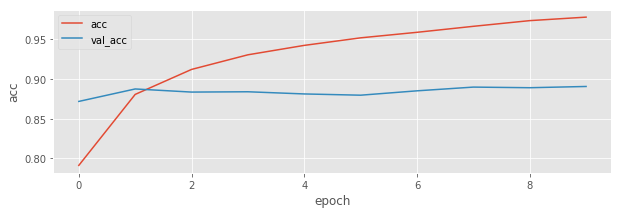

In [126]:
plot_hist(th0, 'acc')

In [137]:
top_m0.save_weights(output_folder + '/gen0_top_model_w_89_028.h5')

<a id='section2.2'.</a>

##### 0.3. Training the whole model

In [145]:
m0 = Model(bm0.input, top_m0(bm0.output))

# for i in m1.layers: i.trainable = True
for layer in bm0.layers[:172]:
    layer.trainable = False
for layer in bm0.layers[172:]:
    layer.trainable = True

m0.compile(Adam(), loss='binary_crossentropy', 
           metrics=['accuracy', recall, precision, fmeasure ])

# m0.load_weights(output_folder + '/whole_model_w_9437.h5')

m0.evaluate(x_test, y_test, batch_size=batch_size)

160/160 [==============================] - 8s     


[0.21469279527664184,
 0.92500000000000004,
 0.91074073314666748,
 0.92727274894714351,
 0.91772871017456059]

In [146]:
m0.optimizer.lr = 0.000000001; print(m0.optimizer.lr)
aug_data_gen = gen_85
batch_size = 128
epochs = 5

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h0 = m0.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                     validation_data=(x_test, y_test))

1e-09
Epoch 1/5
5/5 [==============================] - 25s - loss: 0.7193 - acc: 0.7469 - recall: 0.7489 - precision: 0.7536 - fmeasure: 0.7502 - val_loss: 0.2250 - val_acc: 0.9250 - val_recall: 0.9107 - val_precision: 0.9273 - val_fmeasure: 0.9177
Epoch 2/5
5/5 [==============================] - 11s - loss: 0.6478 - acc: 0.7469 - recall: 0.7701 - precision: 0.7425 - fmeasure: 0.7553 - val_loss: 0.2392 - val_acc: 0.9313 - val_recall: 0.9107 - val_precision: 0.9407 - val_fmeasure: 0.9245
Epoch 3/5
5/5 [==============================] - 11s - loss: 0.7054 - acc: 0.7375 - recall: 0.7669 - precision: 0.7314 - fmeasure: 0.7482 - val_loss: 0.2521 - val_acc: 0.9313 - val_recall: 0.9107 - val_precision: 0.9407 - val_fmeasure: 0.9245
Epoch 4/5
5/5 [==============================] - 11s - loss: 0.6168 - acc: 0.7562 - recall: 0.7658 - precision: 0.7600 - fmeasure: 0.7612 - val_loss: 0.2611 - val_acc: 0.9250 - val_recall: 0.8959 - val_precision: 0.9396 - val_fmeasure: 0.9165
Epoch 5/5
5/5 [=======

22
Prediction: 
 [ 0.  1.  1.]
Label: 
 [ 0.  1.  0.]


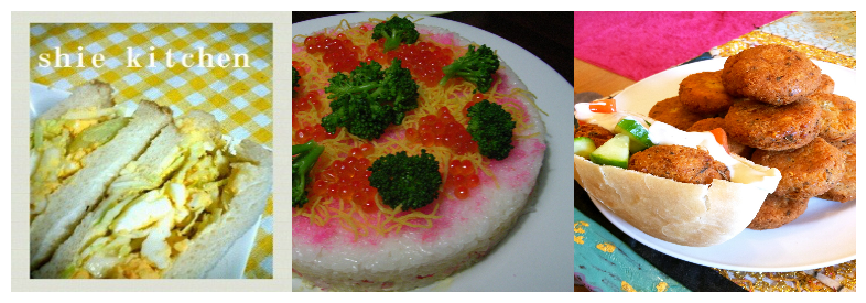

In [108]:
sample_ix = random.randint(0, x_test.shape[0])
print("Prediction: \n", np.round(m0.predict(x_test[sample_ix:sample_ix+3])).ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_images(x_test[sample_ix:sample_ix+3])

In [209]:
# sys.stdout.flush()
m0.save_weights(output_folder + '/gen0_whole_model_w_90_.h5')

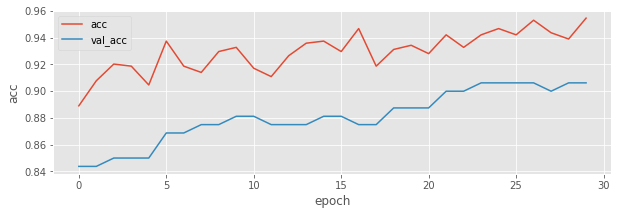

In [211]:
plot_hist(h0, 'acc'); #evaluate(m0, x_test, y_test)

[Table of contents](#top) [Bottom](#bottom) <a id='mobilenet'.</a> 

## Mobilenet

In [6]:


p = 0.5

top_m = Sequential([
        BatchNormalization(input_shape=input_shape_mn),
        #
        Conv2D(32, 3),
        BatchNormalization(),
        Activation('relu'),
#         MaxPooling2D(),
        Conv2D(64, 3),
        BatchNormalization(),
        Activation('relu'),
#         MaxPooling2D(),
        Conv2D(128, 3),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, 3),
#         MaxPooling2D(),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, 3),
#         MaxPooling2D(),
        BatchNormalization(),
        Activation('relu'),
        #
#         MaxPooling2D(), # GlobalAveragePooling2D(),
#         Flatten(),
#         Dropout(p),
#         Dense(256, activation='relu'),
#         BatchNormalization(),
#         Dropout(p),
#         Dense(256, activation='relu'),
#         BatchNormalization(),
#         Dropout(p),
    
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')])


#         x = GlobalAveragePooling2D()(x)
#         x = Reshape(shape, name='reshape_1')(x)
#         x = Dropout(dropout, name='dropout')(x)
#         x = Conv2D(classes, (1, 1),
#                    padding='same', name='conv_preds')(x)
#         x = Activation('softmax', name='act_softmax')(x)
#         x = Reshape((classes,), name='reshape_2')(x)

# top_m01 = Sequential([
#         BatchNormalization(input_shape=bm0.output_shape[1:]),
#         GlobalAveragePooling2D(),
#         Dense(4096),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(.5),
#         Dense(1, activation='sigmoid')])


bm.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure ])

# top_m0.load_weights(output_folder + '/mobilenet_top_model_w_.h5')

In [ ]:
top_m.optimizer.lr = 0.001; print(top_m.optimizer.lr)
aug_data_gen = gen_85
batch_size = 128
epochs = 1

aug_gen = aug_data_gen.flow(x_train, y_train, batch_size=batch_size)

h = top_m.fit_generator(aug_gen, x_train.shape[0]//batch_size, epochs=epochs, 
                          validation_data=(x_test, y_test))

0.001


In [11]:
m = MobileNet()
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [ ]:
top = Sequential([
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(p),
    Conv2D(512, 3, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Conv2D(256, 3, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Conv2D(256, 3, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense
])